In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-


# Deep Neural Networks

## Session 08b - Activation Functions

## Neural Network with
- Multiple hidden layers 
- ${Swish}$ activation function
- Multi-class output
- FIFA dataset 

<img src='../../images/prasami_color_tutorials_small.png' width='400' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
# Lets import some libraries
import os

import numpy as np

import pandas as pd

from time import time

import matplotlib.pyplot as plt

import pickle

from scipy.misc import derivative

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, ConfusionMatrixDisplay

%matplotlib inline

In [3]:
# Some basic parameters
inpDir = '../input'
outDir = '../output'
modelDir = '../models'
subDir = 'fifa_2019'

RANDOM_STATE = 24

np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results

EPOCHS = 30001 # number of epochs
ALPHA = 0.1 # learning rate
TEST_SIZE = 0.2

SAVE_MODEL = False # for saving the model

# parameters for Matplotlib
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 10),
          'axes.labelsize': 'x-large',
          'axes.titlesize':'x-large',
          'xtick.labelsize':'x-large',
          'ytick.labelsize':'x-large'
         }

CMAP = plt.cm.Dark2

plt.rcParams.update(params)

## Read FIFA 2019 data set

In [4]:
data_df = pd.read_csv(os.path.join(inpDir, 'fifa_2019.csv'))
data_df.shape

(18207, 89)

In [5]:
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [6]:
#cols = data_df.columns

#for col in cols:
#    print('\nColumn Name ', col, ':', data_df[col].unique())

In [7]:
# removing rows with position = null

data_df = data_df[data_df["Position"].notnull()]
data_df.head()

,Unnamed: 0,ID,Name,Age,Photo,Nationality,Flag,Overall,Potential,Club,...,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes,Release Clause
0,0,158023,L. Messi,31,https://cdn.sofifa.org/players/4/19/158023.png,Argentina,https://cdn.sofifa.org/flags/52.png,94,94,FC Barcelona,...,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0,€226.5M
1,1,20801,Cristiano Ronaldo,33,https://cdn.sofifa.org/players/4/19/20801.png,Portugal,https://cdn.sofifa.org/flags/38.png,94,94,Juventus,...,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0,€127.1M
2,2,190871,Neymar Jr,26,https://cdn.sofifa.org/players/4/19/190871.png,Brazil,https://cdn.sofifa.org/flags/54.png,92,93,Paris Saint-Germain,...,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0,€228.1M
3,3,193080,De Gea,27,https://cdn.sofifa.org/players/4/19/193080.png,Spain,https://cdn.sofifa.org/flags/45.png,91,93,Manchester United,...,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0,€138.6M
4,4,192985,K. De Bruyne,27,https://cdn.sofifa.org/players/4/19/192985.png,Belgium,https://cdn.sofifa.org/flags/7.png,91,92,Manchester City,...,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0,€196.4M


In [8]:
# Following columns appear to be relevant for our analysis
rel_cols = ["Position", 'Finishing', 'HeadingAccuracy', 'ShortPassing', 'Volleys', 'Dribbling',
            'Curve', 'FKAccuracy', 'LongPassing', 'BallControl', 'Acceleration',
            'SprintSpeed', 'Agility', 'Reactions', 'Balance', 'ShotPower',
            'Jumping', 'Stamina', 'Strength', 'LongShots', 'Aggression',
            'Interceptions', 'Positioning', 'Vision', 'Penalties', 'Composure',
            'Marking', 'StandingTackle', 'SlidingTackle', 'GKDiving', 'GKHandling',
            'GKKicking', 'GKPositioning', 'GKReflexes']

<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.2em;">   
    <h2>Practice - Not for Submissions</h2>

Are there any other columns in the DataFrame, you would like to consider?
<div>

In [9]:
data_df = data_df[rel_cols]
data_df.head()

,Position,Finishing,HeadingAccuracy,ShortPassing,Volleys,Dribbling,Curve,FKAccuracy,LongPassing,BallControl,...,Penalties,Composure,Marking,StandingTackle,SlidingTackle,GKDiving,GKHandling,GKKicking,GKPositioning,GKReflexes
0,RF,95.0,70.0,90.0,86.0,97.0,93.0,94.0,87.0,96.0,...,75.0,96.0,33.0,28.0,26.0,6.0,11.0,15.0,14.0,8.0
1,ST,94.0,89.0,81.0,87.0,88.0,81.0,76.0,77.0,94.0,...,85.0,95.0,28.0,31.0,23.0,7.0,11.0,15.0,14.0,11.0
2,LW,87.0,62.0,84.0,84.0,96.0,88.0,87.0,78.0,95.0,...,81.0,94.0,27.0,24.0,33.0,9.0,9.0,15.0,15.0,11.0
3,GK,13.0,21.0,50.0,13.0,18.0,21.0,19.0,51.0,42.0,...,40.0,68.0,15.0,21.0,13.0,90.0,85.0,87.0,88.0,94.0
4,RCM,82.0,55.0,92.0,82.0,86.0,85.0,83.0,91.0,91.0,...,79.0,88.0,68.0,58.0,51.0,15.0,13.0,5.0,10.0,13.0


In [10]:
# Are there NaNs Still?

data_df.isna().sum()

Position           0
Finishing          0
HeadingAccuracy    0
ShortPassing       0
Volleys            0
Dribbling          0
Curve              0
FKAccuracy         0
LongPassing        0
BallControl        0
Acceleration       0
SprintSpeed        0
Agility            0
Reactions          0
Balance            0
ShotPower          0
Jumping            0
Stamina            0
Strength           0
LongShots          0
Aggression         0
Interceptions      0
Positioning        0
Vision             0
Penalties          0
Composure          0
Marking            0
StandingTackle     0
SlidingTackle      0
GKDiving           0
GKHandling         0
GKKicking          0
GKPositioning      0
GKReflexes         0
dtype: int64

In [11]:
goalkeeper = 'GK'
forward = ['ST', 'LW', 'RW', 'LF', 'RF', 'RS','LS', 'CF']
midfielder = ['CM','RCM','LCM', 'CDM','RDM','LDM', 'CAM', 'LAM', 'RAM', 'RM', 'LM']
defender = ['CB', 'RCB', 'LCB', 'LWB', 'RWB', 'LB', 'RB']

In [12]:
#Assign labels to goalkeepers
data_df.loc[data_df["Position"] == "GK", "Position"] = 0

#Defenders
data_df.loc[data_df["Position"].isin(defender), "Position"] = 1

#Midfielders
data_df.loc[data_df["Position"].isin(midfielder), "Position"] = 2

#Forward
data_df.loc[data_df["Position"].isin(forward), "Position"] = 3

In [13]:
# Convert Column "Position" to numeric so that Pandas does not complain

data_df['Position'] = pd.to_numeric(data_df['Position'], downcast="integer")

In [14]:
# create labels for future display

labels = {0: 'Goal Keeper', 1: 'Defender', 2: 'Mid-Fielder', 3: 'Forward'}

In [15]:
# Separate Features and labels

y = data_df["Position"].values

X = data_df.drop("Position", axis = 1)

In [16]:
# One hot encoding of labels

y = pd.get_dummies(y).values
y

array([[0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [0, 0, 1, 0]], dtype=uint8)

In [17]:
#  Split the data in training and test sets to measure performance of the model.

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=TEST_SIZE, 
                                                    stratify=y,
                                                    random_state=RANDOM_STATE )

print (X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(14517, 33) (14517, 4) (3630, 33) (3630, 4)


In [18]:
# Scaling of data sets
sc = StandardScaler()

X_train = sc.fit_transform(X_train)

X_test = sc.transform(X_test)

# Prepare model

## Activation and Softmax
<p style="font-family: Arial; font-size:1.2em;color:black;">    
So far, we know that for final layer.
<p>
$
\begin{aligned}
z^{[L]} & = a^{[L-1]}. W^{[L]} + b^{[L]} \\
a^{[L]} & = \hat{y} = \mathrm{softmax}(z^{[L]})\\
\end{aligned}
$

<p style="font-family: Arial; font-size:1.2em;color:black;">
    Where:
</p>
$
\begin{aligned}
\mathrm{softmax}(z_i) & =  \frac{e^{z_i}}{\sum\limits_{i = 1}^{L} {e^{z_i}}}\\
\end{aligned}
$
    <p style="font-family: Arial; font-size:1.2em;color:black;">
    Softmax code is for demo purposes only. In general, softmax functions can be highly unstable.Taking instability of Softmax into account, it is recommended to tweak the formula a bit:<br><br>
        $\mathrm{softmax}(z_i) = \large{\frac{e^{z_i – max\left ( z \right )}}{\sum\limits_{i=1}^{L} e^{z_i- max\left ( z \right )}}}$</p>
    
<div class="alert alert-block alert-warning" style="font-family: Arial; font-size:1.2em;"> 
    <b>Note:</b> If you must implement softmax, use libraries such as <b><i>scipy.special.softmax.</i></b>
</div>


In [19]:
def fn_softmax(z):
    
    '''
    Args:
        z : a matrix of z values of shape (m, n_output)
    returns:
        Softmax values of z
    
    '''
    
    #exp_scores = np.exp(z - np.amax(z, axis = 1, keepdims = True))
    exp_scores = np.exp(z)

    return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)
    

In [20]:
def fn_actv(z):
    '''
    Args:
        z: array z value
    Returns:
        a: array - activations
    '''
    
    return z  / (1 + np.exp(-z))

def fn_actv_prime(z):
    '''
    Args:
        z: array
    Returns:
        a: array - activation prime
    '''

    return derivative(fn_actv, z, dx=1e-6)

### Loss Function

In [21]:
# Helper function to evaluate the total loss on the dataset

def calculate_loss(model, X_l, y_l):
    '''
    Args:
        model: dictionay object containing weights and biases
        X_l: Feature Matrix
        y_l: Labels matrix (One-hot encoding expected)
    Returns:
        Average loss
    '''
    
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
    
    m = X_l.shape[0] # Number of rows will change for X_test and X_train
    
    # Layer 1
    z1 = X_l.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_softmax(z2) # Activation
    
    # Calculating the loss
    data_loss = -(y_l * np.log(a2) + (1 - y_l) * np.log(1 - a2) ).sum() 

    return 1./m * data_loss

## Predict Function

For predictions, we will simply be using the forward propagation. No need to iterate or calculate the back propagation.


In [22]:
# Helper function to predict an output

def predict(model, X_p):
    '''
     Args:
         model: dict object containing weights and biases
         X_p: Feature Matrix
    Returns:
        Predictions against the instances
         
    '''
    # Extract Weights and biases from the model
    W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']  
    
    # Layer 1
    z1 = X_p.dot(W1) + b1  # Aggregation
    a1 = fn_actv(z1)     # Activation

    # Layer 2
    z2 = a1.dot(W2) + b2 # Aggregation
    a2 = fn_softmax(z2)     # Activation

    return np.argmax(a2, axis = 1)

**Note:** 
1. Following function will load model if exists, otherwise train from scratch
2. In case of gradient explosion change the initializer say for swish use glorot_normal. Draws samples from a truncated normal distribution centered on 0 with stddev = sqrt(2 / (fan_in + fan_out)) 


In [23]:
# Prepare the Model

def build_model(nn_hdim, 
                X : np.ndarray, y : np.ndarray,
                X_t: np.ndarray, y_t: np.ndarray,
                alpha = 0.1,
                epochs = 20000, 
                print_loss=False):
    
    '''
    Args:
        nn_hdim : number of nodes in hidden layer
        X   : Training features to train
        y   : Trainig targets (labels)
        X_t : Testing features to train
        y_t : Testing targets (labels)
        alpha : learning rate
        epochs : Number of passes through the training data for gradient descent
        print_loss : If True, print the loss every nnn iterations
        
    Returns:
        Model: Dictionary object containing weights and biases
    '''
    if os.path.isfile(modelFilePath):
        print (f'Pre-trained model found at {modelFilePath}. Loading....')
        
        with open(modelFilePath, 'rb') as file:
            model_details = pickle.load(file)
            model = model_details['weights']
        print (f'Loaded existing model with\n {model_details["description"]}\n\n')
        print ('#'*50)
        W1, b1, W2, b2 = model['W1'], model['b1'], model['W2'], model['b2']
        
    else:
        print (f'No model found at {modelFilePath}. Initializing....')

        W1 = np.random.rand(nn_input_dim, nn_hdim) / np.sqrt(nn_input_dim) # as per Lacun Normal
        b1 = np.zeros((1, nn_hdim))
        
        W2 = np.random.rand(nn_hdim, nn_output_dim) / np.sqrt(nn_hdim)
        b2 = np.zeros((1, nn_output_dim))
    
        model ={}
    
    startTime = time()
    
    curr_loss = 0
    epoch, loss, t_loss, acc, t_acc = [], [], [], [], []
    num_examples = X.shape[0] # training set size
    
    for i in range(0, epochs):
        
        epochTime = time()
        
        #### Forward ------------------------------
        # Layer 1
        z1 = X.dot(W1) + b1 
        a1 = fn_actv(z1)    # activation
        
        # Layer 2
        z2 = a1.dot(W2) + b2 
        a2 = fn_softmax(z2)    # activation
        
        
        ### Back Prop ------------------------------
        #Layer 2
        dz2 = a2- y
       
        dW2 = (a1.T).dot(dz2)  
        assert(W2.shape == dW2.shape), 'Shape of W2 {} and dW2 {} do not match'.format(W2.shape, dW2.shape)
        
        db2 = np.sum(dz2, axis=0, keepdims=True)
        assert(b2.shape == db2.shape), 'Shape of b2 {} and db2 {} do not match'.format(b2.shape, db2.shape)
        
        da1= dz2.dot(W2.T)
        
        #Layer 1
        dz1 = da1 * fn_actv_prime(a1)
        dW1 = (X.T).dot(dz1)
        assert(W1.shape == dW1.shape), 'Shape of W1 {} and dW1 {} do not match'.format(W1.shape, dW1.shape)
        
        db1 = np.sum(dz1, axis=0, keepdims=True)
        assert(b1.shape == db1.shape), 'Shape of b1 {} and db1 {} do not match'.format(b1.shape, db1.shape)
        
        
        # Weights update
        W1 += -alpha * dW1 /num_examples
        b1 += -alpha * db1 /num_examples
        
        W2 += -alpha * dW2 /num_examples
        b2 += -alpha * db2 /num_examples
        
        
        model = {'W1': W1, 'b1': b1,
                 'W2': W2, 'b2': b2}
        
        if i % 100 == 0:
            
            # Keep count of epoch
            epoch.append(i)
            
            # Calculate loss
            curr_loss = calculate_loss (model, X, y)
            loss.append(curr_loss)
            
            ct_loss = calculate_loss ( model, X_t, y_t)
            t_loss.append(ct_loss)
            
            # Calculate accuracy
            y_pred = predict(model, X)
            curr_acc = accuracy_score(np.argmax(y, axis = 1), y_pred )
            acc.append(curr_acc)
            
            yt_pred = predict(model, X_t)
            currt_acc = accuracy_score(np.argmax(y_t, axis = 1), yt_pred )
            t_acc.append(currt_acc)
            
        # Print the loss.
        if print_loss and i % 1000 == 0:
            print(f'Epoch # :{i}')
            print('Time of execution till now: {:0.2f} mins'.format( (time() - startTime ) / 60.) )
            print('Last epoch: {:0.2f} ms'.format ( (time() - epochTime) * 1000 ) )
            print('Train: Loss: %f  ---- Accuracy: %f' %(curr_loss, curr_acc))
            print('Test:  Loss: %f  ---- Accuracy: %f' %(ct_loss, currt_acc))
            print("-" *50)
    
    loss_hist['epoch'] = epoch
    loss_hist['loss'] = loss
    loss_hist['test_loss'] = t_loss
    loss_hist['acc'] = acc
    loss_hist['test_acc'] = t_acc
    
    return model

In [24]:
nn_input_dim = X_train.shape[1] # input layer dimensionality
nn_output_dim = y_train.shape[1] # output layer dimensionality

nn_hidden_dim = 18

alpha = ALPHA

epochs = EPOCHS

In [25]:
loss_hist = {}

modelFilePath = os.path.join(modelDir,subDir, 'S07_fifa_1L_model_swish.pkl')

model = build_model(nn_hidden_dim, X_train, y_train, X_test, y_test, alpha, epochs, print_loss = True) 


No model found at ../models/fifa_2019/S07_fifa_1L_model_swish.pkl. Initializing....
Epoch # :0
Time of execution till now: 0.00 mins
Last epoch: 45.95 ms
Train: Loss: 2.178070  ---- Accuracy: 0.458153
Test:  Loss: 2.173204  ---- Accuracy: 0.459780
--------------------------------------------------
Epoch # :1000
Time of execution till now: 0.33 mins
Last epoch: 36.93 ms
Train: Loss: 0.680624  ---- Accuracy: 0.860922
Test:  Loss: 0.672333  ---- Accuracy: 0.852342
--------------------------------------------------
Epoch # :2000
Time of execution till now: 0.66 mins
Last epoch: 42.48 ms
Train: Loss: 0.594372  ---- Accuracy: 0.874423
Test:  Loss: 0.581164  ---- Accuracy: 0.876033
--------------------------------------------------
Epoch # :3000
Time of execution till now: 1.03 mins
Last epoch: 43.72 ms
Train: Loss: 0.580877  ---- Accuracy: 0.877936
Test:  Loss: 0.567186  ---- Accuracy: 0.880441
--------------------------------------------------
Epoch # :4000
Time of execution till now: 1.41 

In [26]:
loss_df = pd.DataFrame(loss_hist)
loss_df.shape

(301, 5)

In [27]:
model_details = {}

model_details['description'] = f'''Hidden layers : 1;
Layer sizes: 
    Input-{nn_input_dim}; Hidden-{nn_hidden_dim},Output-{nn_output_dim}'''

model_details['weights'] = model

if SAVE_MODEL:
    
    with open(modelFilePath, 'wb') as file:
        pickle.dump(model_details, file, protocol=pickle.HIGHEST_PROTOCOL)
        
    loss_df.to_csv(os.path.join(modelDir, subDir, 'S07_fifa_1L_model_loss.csv'))

In [28]:
print ('Model Weights:\n', model.keys())

Model Weights:
 dict_keys(['W1', 'b1', 'W2', 'b2'])


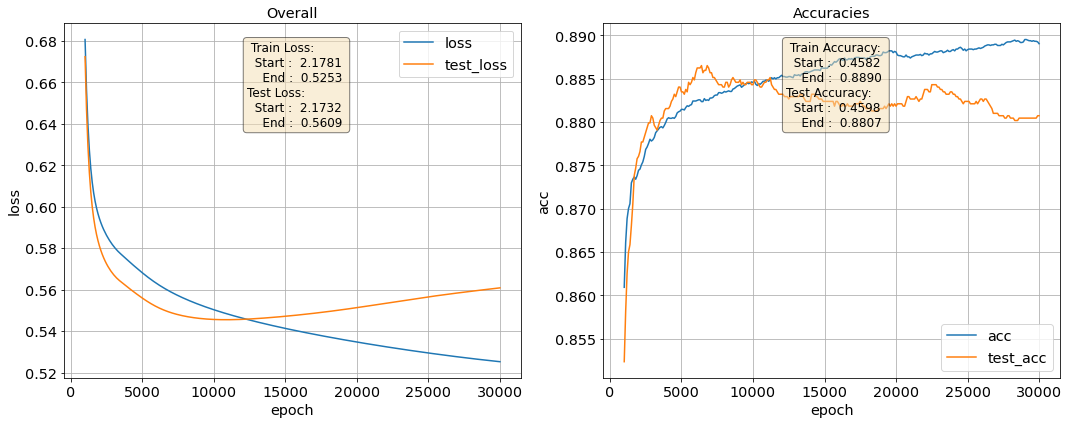

In [29]:
fig, axes = plt.subplots(1,2 , figsize = (15,6),)

l_range = 10 # ignoring first few records
x_var = 'epoch'
y1_var = 'loss'
y2_var = 'test_loss'

ax = axes[0]

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Loss: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
# properties  matplotlib.patch.Patch 
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Overall')
ax.grid();

ax = axes[1]

y1_var = 'acc'
y2_var = 'test_acc'

loss_df[l_range:].plot(x = x_var, y = [y1_var, y2_var], ax = ax)

# get values for plotting
st_loss = loss_df[y1_var].iloc[0]
end_loss = loss_df[y1_var].iloc[-1]
t_st_loss = loss_df[y2_var].iloc[0]
t_end_loss = loss_df[y2_var].iloc[-1]

# little beautification
train_txtstr = "Train Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( st_loss, end_loss )    # Train text to plot

test_txtstr = "Test Accuracy: \n  Start : {:7.4f}\n    End : {:7.4f}".format( t_st_loss, t_end_loss ) # Test text to plot# properties  matplotlib.patch.Patch 
txtstr = ' {} \n{}'.format(train_txtstr, test_txtstr)
props = dict(boxstyle='round', facecolor='wheat', alpha=0.5)

# place a text box in upper left in axes coords

ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=12,
        verticalalignment='top', bbox=props)

ax.set_xlabel(x_var)
ax.set_ylabel(y1_var)
ax.set_title('Accuracies'.format(l_range))
ax.grid();
plt.tight_layout()

In [30]:
y_pred = predict(model, X_train)
print('Accuracy score on Train Data :{:.5f}'.format( accuracy_score(np.argmax(y_train, axis = 1), y_pred ) ) )

Accuracy score on Train Data :0.88903


In [31]:
print(classification_report(np.argmax(y_train, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1620
           1       0.93      0.93      0.93      4693
           2       0.84      0.87      0.86      5470
           3       0.86      0.78      0.82      2734

    accuracy                           0.89     14517
   macro avg       0.91      0.90      0.90     14517
weighted avg       0.89      0.89      0.89     14517



In [32]:
y_pred = predict(model, X_test)

print('Accuracy score on Test Data :{:.5f}'.format(accuracy_score(np.argmax(y_test, axis = 1), y_pred)))

Accuracy score on Test Data :0.88072


In [33]:
print(classification_report(np.argmax(y_test, axis = 1), y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       405
           1       0.92      0.92      0.92      1173
           2       0.83      0.87      0.85      1368
           3       0.86      0.76      0.81       684

    accuracy                           0.88      3630
   macro avg       0.90      0.89      0.89      3630
weighted avg       0.88      0.88      0.88      3630



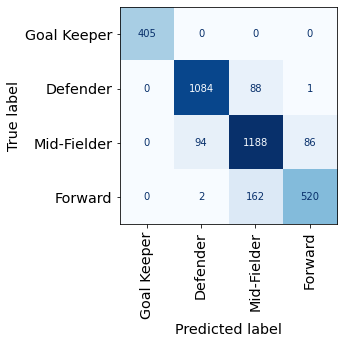

In [34]:
cm  = confusion_matrix(np.argmax(y_test, axis = 1), y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels.values())

fig, ax = plt.subplots(figsize = (4,4))

disp.plot(ax = ax, cmap = 'Blues', xticks_rotation = 'vertical', colorbar=False)

plt.show();

In [35]:
loss_df[loss_df['test_loss'] == loss_df['test_loss'].min()]

,epoch,loss,test_loss,acc,test_acc
108,10800,0.548581,0.5455,0.884687,0.884573
